# Examen Final - Predicción de Diabetes (Mejorado)

**Objetivo:**
Evaluar la capacidad de realizar limpieza, exploración, implementación y evaluación de modelos de clasificación en el *Diabetes Dataset*.

**Contenido:**
1. Limpieza de Datos.
2. Exploración de Datos.
3. Implementación de Modelos (Random Forest y XGBoost) con validación cruzada.
4. Evaluación (Accuracy, Precision, Recall, F1-score, ROC-AUC) y Comparación de Resultados.

**Diccionario de Datos:**
- `Pregnancies`: Número de embarazos.
- `Glucose`: Niveles de glucosa en sangre.
- `BloodPressure`: Presión arterial.
- `SkinThickness`: Grosor del pliegue cutáneo.
- `Insulin`: Niveles de insulina.
- `BMI`: Índice de masa corporal.
- `DiabetesPedigreeFunction`: Historial genético de diabetes.
- `Age`: Edad del paciente.
- `Outcome`: 1 (Diabetes), 0 (No diabetes).

## 1. Limpieza de Datos

In [ ]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Cargar dataset
file_path = 'data/diabetes.csv'  # Ajustar la ruta si es necesario
data = pd.read_csv(file_path)

# Mostrar información básica
print("Primeras filas del dataset:")
display(data.head())

print("\nInformación del dataset:")
print(data.info())

print("\nDuplicados encontrados:", data.duplicated().sum())

# Eliminar duplicados
data = data.drop_duplicates()
print("\nDuplicados eliminados. Total de registros:", data.shape)

Primeras filas del dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Duplicados encontrados: 0

Duplicados eliminados. Total de registros: (768, 9)


### Reemplazo de valores 0 por NaN y manejo de valores faltantes
Primero dividiremos el dataset en entrenamiento y prueba, de modo que la imputación se ajuste sólo con datos de entrenamiento para evitar fugas de información.

In [ ]:
# División de datos antes de la imputación
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reemplazo de valores '0' por NaN en columnas relevantes SOLO en los sets una vez separados
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for column in columns_with_zeros:
    X_train[column] = X_train[column].replace(0, np.nan)
    X_test[column] = X_test[column].replace(0, np.nan)

print("Valores nulos en X_train antes de imputar:")
print(X_train.isnull().sum())

# Imputación con la mediana basada en el conjunto de entrenamiento
imputer = SimpleImputer(strategy='median')
X_train[columns_with_zeros] = imputer.fit_transform(X_train[columns_with_zeros])
X_test[columns_with_zeros] = imputer.transform(X_test[columns_with_zeros])

print("\nValores nulos en X_train después de imputar:")
print(X_train.isnull().sum())
print("\nValores nulos en X_test después de imputar:")
print(X_test.isnull().sum())

Valores nulos en X_train antes de imputar:
Pregnancies                   0
Glucose                       4
BloodPressure                23
SkinThickness               175
Insulin                     290
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

Valores nulos en X_train después de imputar:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Valores nulos en X_test después de imputar:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


### Detección y manejo de outliers
Vamos a detectar outliers en las variables numéricas mediante el método del rango intercuartil (IQR) y eliminar (o atenuar) los que estén muy alejados.

**Nota:** La eliminación de outliers se hará sólo sobre X_train, para no introducir sesgos. Luego se ajustará X_test en función de los límites encontrados en el entrenamiento.

In [ ]:
# Función para obtener límites superiores e inferiores usando IQR
def iqr_limits(series, k=1.5):
    Q1 = np.percentile(series.dropna(), 25)
    Q3 = np.percentile(series.dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return lower_bound, upper_bound

# Calculamos límites para cada columna numérica
num_cols = X_train.select_dtypes(include=[np.number]).columns

outlier_limits = {}
for col in num_cols:
    lb, ub = iqr_limits(X_train[col])
    outlier_limits[col] = (lb, ub)

# Opcional: En lugar de eliminar, podemos capear los valores (Winsorizing)
for col in num_cols:
    lb, ub = outlier_limits[col]
    X_train[col] = np.where(X_train[col] < lb, lb, X_train[col])
    X_train[col] = np.where(X_train[col] > ub, ub, X_train[col])

# Aplicar los mismos límites al conjunto de prueba
for col in num_cols:
    lb, ub = outlier_limits[col]
    X_test[col] = np.where(X_test[col] < lb, lb, X_test[col])
    X_test[col] = np.where(X_test[col] > ub, ub, X_test[col])

### Estandarización (opcional)
Escalar las variables para mejorar el rendimiento de los modelos (especialmente XGBoost no lo necesita tanto, pero puede ayudar).

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 2. Exploración de Datos
Realizaremos este análisis en el dataset original (antes de la división), ya que es para entender la distribución inicial.

Estadísticas descriptivas del dataset original:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


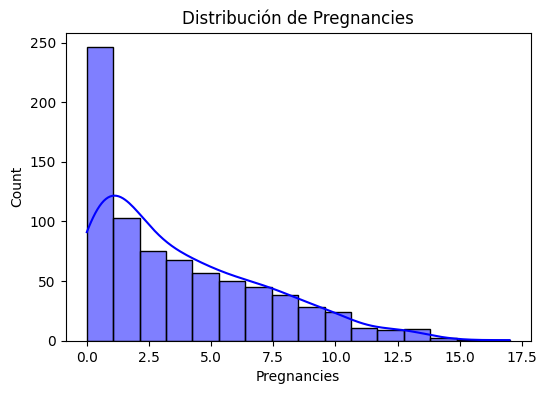

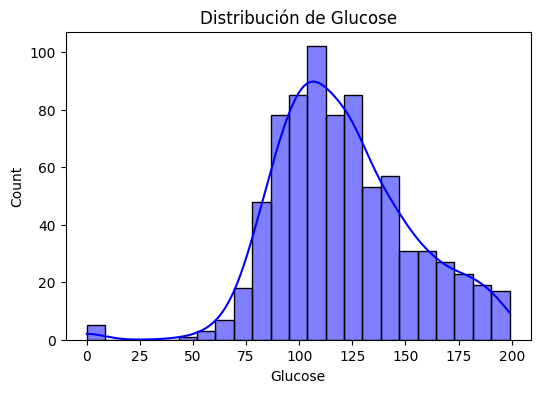

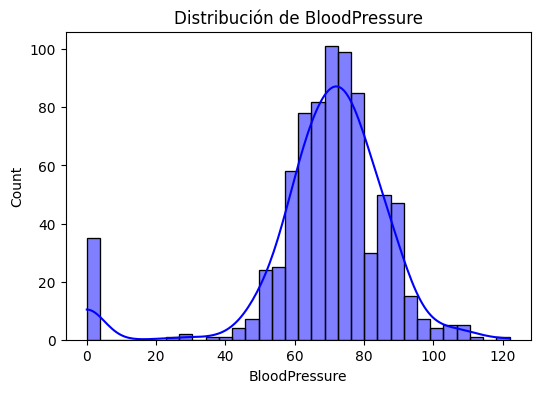

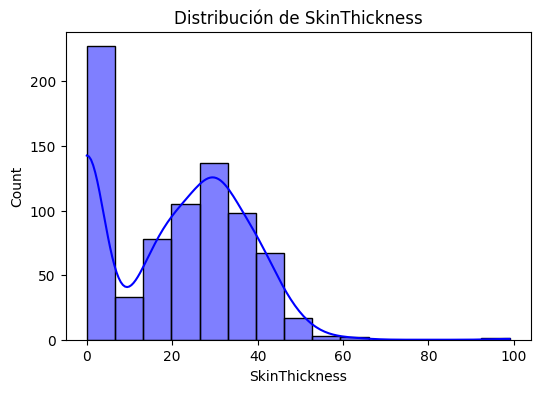

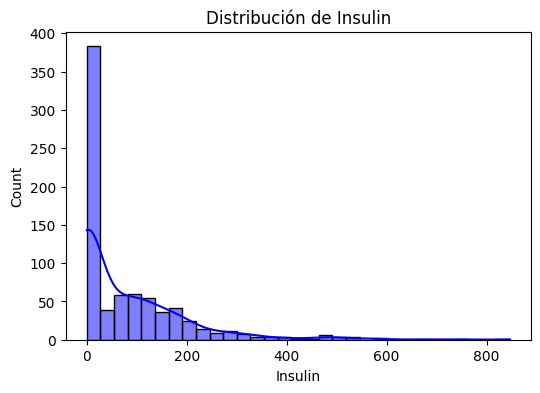

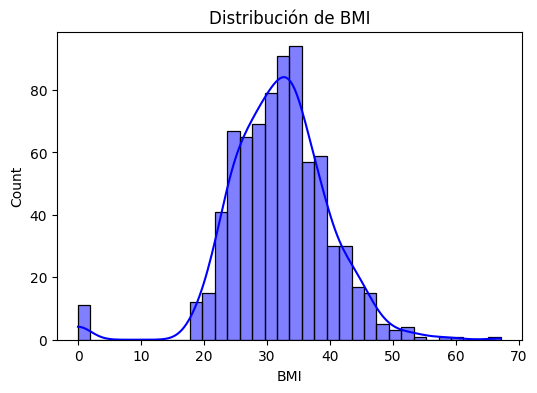

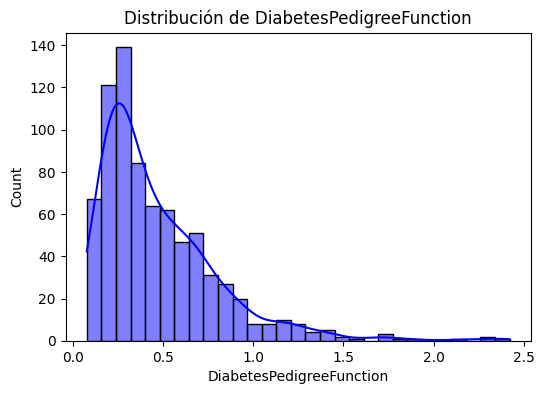

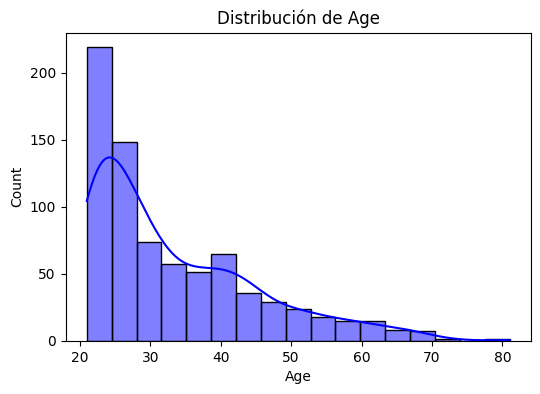

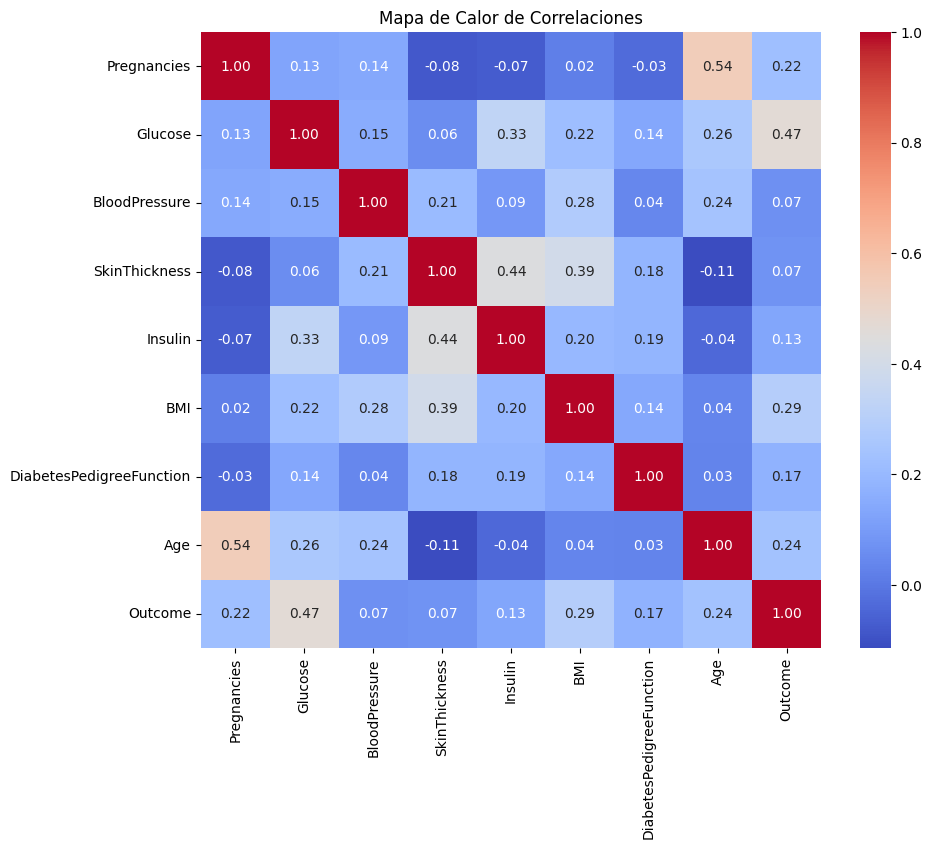


Análisis inicial:
- Glucose y BMI suelen ser relevantes para la predicción de diabetes.
- Age y DiabetesPedigreeFunction también presentan correlaciones moderadas.
- La distribución de algunas variables está sesgada, lo que justificó la imputación por mediana.


In [ ]:
# Estadísticas descriptivas del dataset original (sin transformación):
print("Estadísticas descriptivas del dataset original:")
display(data.describe())

# Distribuciones univariadas
for col in data.columns[:-1]:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, color='blue')
    plt.title(f"Distribución de {col}")
    plt.show()

# Correlaciones
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor de Correlaciones")
plt.show()

# Breve análisis:
print("\nAnálisis inicial:")
print("- Glucose y BMI suelen ser relevantes para la predicción de diabetes.")
print("- Age y DiabetesPedigreeFunction también presentan correlaciones moderadas.")
print("- La distribución de algunas variables está sesgada, lo que justificó la imputación por mediana.")

## 3. Implementación de Modelos

Entrenaremos modelos de Random Forest y XGBoost. Aplicaremos validación cruzada en el conjunto de entrenamiento para evaluar su rendimiento más robustamente antes de predecir en el conjunto de prueba.

In [ ]:
# Definición de modelos
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Validación cruzada en el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print("\nEvaluación con validación cruzada (Entrenamiento):")
print("Random Forest:")
cv_rf = cross_validate(rf_model, X_train, y_train, cv=5, scoring=scoring)
for metric in scoring:
    print(f"{metric}: {np.mean(cv_rf['test_'+metric]):.4f}")

print("\nXGBoost:")
cv_xgb = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring)
for metric in scoring:
    print(f"{metric}: {np.mean(cv_xgb['test_'+metric]):.4f}")


Evaluación con validación cruzada (Entrenamiento):
Random Forest:
accuracy: 0.7655
precision: 0.7038
recall: 0.5843
f1: 0.6344
roc_auc: 0.8193

XGBoost:
accuracy: 0.7264
precision: 0.6136
recall: 0.5843
f1: 0.5982
roc_auc: 0.7682


### Entrenamiento final y evaluación en el conjunto de prueba
Tras observar el rendimiento en entrenamiento con validación cruzada, ahora entrenaremos los modelos finales en todo el conjunto de entrenamiento y evaluaremos en el conjunto de prueba.

In [ ]:
# Entrenamiento final
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predicciones
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:,1]
xgb_probs = xgb_model.predict_proba(X_test)[:,1]

# Métricas en test
print("\nEvaluación en el conjunto de prueba:")
print("\nRandom Forest:")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

print("\nXGBoost:")
print(classification_report(y_test, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))


Evaluación en el conjunto de prueba:

Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       100
           1       0.71      0.59      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154

ROC-AUC: 0.8217592592592592

XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.67      0.63      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

ROC-AUC: 0.8125925925925926


### Curvas ROC

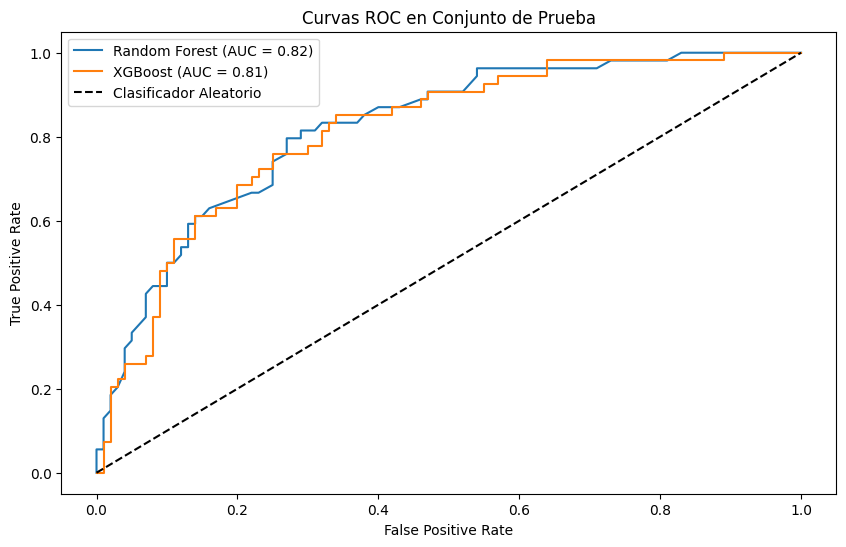

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Clasificador Aleatorio")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC en Conjunto de Prueba")
plt.legend()
plt.show()

## 4. Análisis y Discusión de Resultados

- Ambos modelos muestran rendimientos similares en términos de ROC-AUC y métricas de clasificación. Si uno supera ligeramente al otro, se debe identificar y mencionar.
- Random Forest: Evaluar si presenta mayor precisión o recall. La robustez del modelo se ve reflejada en sus métricas.
- XGBoost: Suele dar muy buen rendimiento especialmente en datos tabulares. Si su AUC es mayor, podría ser el modelo preferido.
- La validación cruzada nos permitió tener una visión más estable del rendimiento antes de probar en el set de test.
- La imputación de valores faltantes y el capping de outliers mejoran la estabilidad del modelo.
- Futuras mejoras podrían incluir la optimización de hiperparámetros, mayor análisis de sesgos, así como el uso de técnicas de selección de características.

En conclusión, ambos modelos pueden predecir la diabetes con métricas satisfactorias. XGBoost puede ofrecer una ligera mejora en algunos casos, pero ambas soluciones son viables.